In [32]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

import importlib

import os
import crypto_object
from datetime import timedelta

In [25]:
crypto_object = importlib.reload(crypto_object)

def load_coins(dir_):
    """
    Function to take in a directory containing data
    and return a dictionary of `Coin` objects
    """
    
    # to store data
    coin_dict = {}
    
    for filename in os.listdir(dir_):
        
        # price data
        if filename.endswith("_price.csv"):
            
            # coin name
            coin_name = filename.split('_')[0]
            
            coin_dict[coin_name] = crypto_object.Coin(coin_name, dir_ + filename)
            
    return coin_dict

In [26]:
coins = load_coins('cryptocurrencypricehistory/')

In [30]:
[coins[k].start for k in coins.keys()]

[Timestamp('2013-04-28 00:00:00'),
 Timestamp('2017-01-20 00:00:00'),
 Timestamp('2014-02-14 00:00:00'),
 Timestamp('2015-08-07 00:00:00'),
 Timestamp('2017-06-13 00:00:00'),
 Timestamp('2013-04-28 00:00:00'),
 Timestamp('2014-05-21 00:00:00'),
 Timestamp('2015-04-01 00:00:00'),
 Timestamp('2016-09-09 00:00:00'),
 Timestamp('2017-06-23 00:00:00'),
 Timestamp('2017-07-14 00:00:00'),
 Timestamp('2017-05-24 00:00:00'),
 Timestamp('2013-08-04 00:00:00'),
 Timestamp('2016-08-12 00:00:00'),
 Timestamp('2016-06-02 00:00:00')]

In [82]:
class Portfolio():
    """
    Portfolio Object for Backtester
    
    weights associated with coins. Ensures can not hold 
    coins that have not been created yet
    """
    
    def __init__(self, name, time, coin_dict, weight_dict, starting_value):
        self.name = name
        self.t = time
        self.coin_dict = coin_dict
        self.weight_dict = self.normalize_weights(weight_dict)
        self.total_value = starting_value
        self.coin_values = {k : starting_value * self.weight_dict[k] for k in self.coin_dict.keys()}
        
    def normalize_weights(self, weight_dict):
        ws = np.nansum(list(weight_dict.values()))
        return {k : weight_dict[k] / ws for k in weight_dict.keys()}
        
    def update(self, weight_dict):
        """
        Update Portfolio after each day
        """
        
        # create dict for returns of each coin
        returns_dict = {}
        self.t = self.t + timedelta(days=1)
        
        self.weight_dict = self.normalize_weights(weight_dict)
        
        # ensure coins that have not been created yet 
        for k in self.weight_dict.keys():
            if self.coin_dict[k].start > self.t:
                print('Coin Weight Premature')
                self.weight_dict[k] = 0
        
        self.coin_values = {k : self.total_value * self.weight_dict[k] for k in self.coin_dict.keys()}
        
        # create returns dictionary
        for k in self.coin_dict.keys():
            returns_dict[k] = self.coin_dict[k].full_data['Pct Returns'][np.argwhere(self.coin_dict[k].full_data['Date'] == self.t)[0][0]]
            
        for k in self.coin_dict.keys():
            self.coin_values[k] = self.coin_values[k] * (1 + returns_dict[k])
                
        # get new total_value
        self.total_value = np.nansum(list(self.coin_values.values()))

In [109]:
import datetime

p = Portfolio(
    'Test',
    coins['bitcoin'].full_data['Date'][50],
    coins,
    {k : 2 for k in coins.keys()},
    1000
)

In [110]:
N=40
vals = np.empty((N,))

for i in np.arange(N):
    p.update({k : np.random.uniform() for k in coins.keys()})
    vals[i] = p.total_value

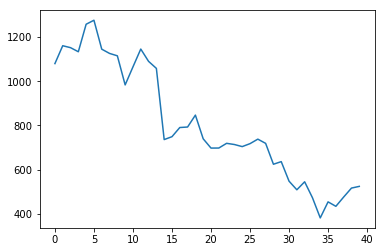

In [111]:
plt.plot(vals)